<a href="https://colab.research.google.com/github/zseebrz/colab/blob/main/Day_2_Solution_Earnings_Tabular_DeltaPy_CTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Data, Big Insights workshop

## Tabular Data Practice notebook
LAB Day 2

Created by Miklos Toth

Co-Author: Levente Szabados 

In [1]:
!pip install imbalanced-learn
!pip install deltapy
!pip install ctgan


In [2]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, r2_score
import matplotlib.pyplot as plt 
from collections import defaultdict
from tqdm import tqdm
import random 
SEED=42

In [3]:
%matplotlib inline

# Dataset: Earnings reports and price changes
<img src="https://storage.googleapis.com/kaggle-datasets-images/145153/338948/82c9fa37fb54a0c6fc5ce581a6a42b37/dataset-cover.jpg?t=2019-03-21-21-24-43">

source: https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data

What is the earnings release for a stock? https://www.investopedia.com/terms/e/earningsreport.asp

What Is Earnings Per Share – EPS?
https://www.investopedia.com/terms/e/eps.asp

Every quarter, analysts and investors wait for the announcement of company earnings. The announcement of earnings for a stock, particularly for well followed large capitalization stocks, can move the market. Stock prices can fluctuate wildly on days when the quarterly earnings report is released.

For better or worse, a company's ability to beat earnings estimates projected by analysts or the firm itself is more important than the company's ability to grow earnings over the prior year. For example, if the company reports earnings growth from the prior period in its quarterly earnings report, but fails to meet or exceed the estimates published before the release, it may result in a sell-off of the stock. In many ways, analysts estimates are just as important as the earnings report itself.

In [4]:
# download, here you could use wget https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data
!gdown https://drive.google.com/uc?id=1zFtzGIJGFpWG_OdxqzseT1X42SBhw-Fv

Downloading...
From: https://drive.google.com/uc?id=1zFtzGIJGFpWG_OdxqzseT1X42SBhw-Fv
To: /content/stock_data_from_kaggle.zip
456MB [00:05, 91.1MB/s]


In [5]:
!unzip -o stock_data_from_kaggle.zip

Archive:  stock_data_from_kaggle.zip
  inflating: dataset_summary.csv     
  inflating: stocks_latest/dividends_latest.csv  
  inflating: stocks_latest/earnings_latest.csv  
  inflating: stocks_latest/stock_prices_latest.csv  


# Data Exploration 

In [6]:
summarydf=pd.read_csv("dataset_summary.csv")
print("nr. of companies: ",len(summarydf))
summarydf

nr. of companies:  7091


,symbol,total_prices,stock_from_date,stock_to_date,total_earnings,earnings_from_date,earnings_to_date
0,A,5246,1999-11-18,2020-09-24,46,2009-05-14,2020-08-18
1,AA,981,2016-11-01,2020-09-24,15,2017-01-24,2020-07-15
2,AAAP,574,2015-11-11,2018-07-18,0,NaN,NaN
3,AABA,5486,1998-01-02,2020-03-10,14,2014-01-28,2017-04-18
4,AAC,1294,2014-10-02,2020-07-02,22,2014-11-05,2019-08-30
...,...,...,...,...,...,...,...
7086,ZVO,2875,2009-04-15,2020-09-14,5,2019-05-09,2020-08-03
7087,ZX,1784,2011-05-16,2018-07-19,0,NaN,NaN
7088,ZYME,855,2017-04-28,2020-09-18,14,2017-05-15,2020-08-05
7089,ZYNE,1089,2015-08-05,2019-11-29,21,2015-08-27,2020-08-10


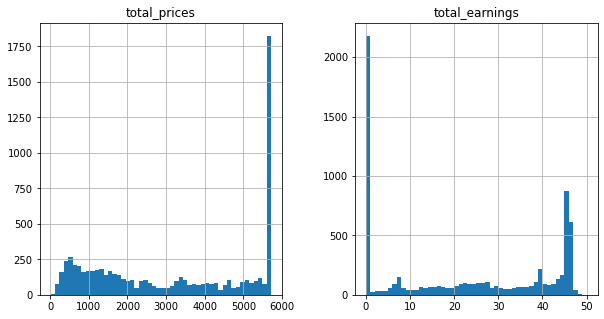

In [7]:
summarydf.hist(bins=50,figsize=(10,5))
plt.show()

In [8]:
stock_pricedf=pd.read_csv("stocks_latest/stock_prices_latest.csv")
stock_pricedf

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.8000,51.9600,50.7500,51.8300,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.8500,69.8400,67.8500,67.8700,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.4100,55.0000,53.1700,54.3200,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.0100,36.0300,34.5600,35.0300,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.6100,42.2900,41.5100,42.2500,38.6773,74640000,1.0
...,...,...,...,...,...,...,...,...,...
22824528,MTNB,2020-09-22,0.7995,0.8098,0.7723,0.7953,0.7953,1107081,1.0
22824529,MTNB,2020-09-23,0.8097,0.8100,0.7820,0.7929,0.7929,1336844,1.0
22824530,MTNB,2020-09-16,0.8000,0.8100,0.7590,0.7784,0.7784,1478516,1.0
22824531,MTNB,2020-09-17,0.7784,0.8000,0.7553,0.7961,0.7961,1460562,1.0


In [9]:
earningsdf=pd.read_csv("stocks_latest/earnings_latest.csv")
earningsdf

,symbol,date,qtr,eps_est,eps,release_time
0,A,2009-05-14,04/2009,NaN,NaN,post
1,A,2009-08-17,07/2009,NaN,NaN,post
2,A,2009-11-13,10/2009,NaN,NaN,pre
3,A,2010-02-12,01/2010,NaN,NaN,pre
4,A,2010-05-17,04/2010,NaN,NaN,post
...,...,...,...,...,...,...
157352,ZYXI,2019-07-31,Q2,0.060,0.06,NaN
157353,ZYXI,2019-10-29,Q3,0.057,0.06,post
157354,ZYXI,2020-02-27,Q4,0.077,0.09,post
157355,ZYXI,2020-04-28,Q1,0.063,0.09,post


In [10]:
min_earnings_symbol=summarydf[summarydf["total_earnings"]>20]
min_earnings_symbol


,symbol,total_prices,stock_from_date,stock_to_date,total_earnings,earnings_from_date,earnings_to_date
0,A,5246,1999-11-18,2020-09-24,46,2009-05-14,2020-08-18
4,AAC,1294,2014-10-02,2020-07-02,22,2014-11-05,2019-08-30
5,AAL,3772,2005-09-27,2020-09-21,27,2014-01-28,2020-07-23
6,AAMC,1959,2012-12-13,2020-09-24,23,2013-05-09,2018-11-07
7,AAME,5717,1998-01-02,2020-09-21,39,2009-05-14,2018-11-13
...,...,...,...,...,...,...,...
7074,ZNGA,2204,2011-12-16,2020-09-21,34,2012-02-14,2020-08-05
7079,ZSAN,1424,2015-01-27,2020-09-21,21,2015-05-11,2020-08-06
7083,ZTS,1922,2013-02-01,2020-09-18,30,2013-04-30,2020-08-06
7084,ZUMZ,3871,2005-05-06,2020-09-21,46,2009-05-21,2020-09-10


In [11]:
#

keys = list(min_earnings_symbol["symbol"].values)
earnings_limited_df=earningsdf[earningsdf["symbol"].isin(keys)]
len(earnings_limited_df)

142489

Lets double-check if this is right.

In [12]:
earnings_limited_df.groupby("symbol").count().sort_values("eps").iloc[0:25]

,date,qtr,eps_est,eps,release_time
symbol,,,,,
FSBC,22,22,0,9,1
SNN,23,22,12,11,7
ATV,25,25,0,11,22
HMY,22,22,2,13,0
CNTF,28,28,0,14,16
AMCN,27,27,3,15,26
AU,25,25,9,15,1
DSWL,28,28,0,15,9
SPEX,29,29,1,16,0


not exactly. This means the summary table is not reliable.

In [13]:
earnings_statistics=earningsdf.groupby("symbol").count()
keys=earnings_statistics[earnings_statistics["eps"]>20].index
earnings_limited_df=earningsdf[earningsdf["symbol"].isin(keys)].copy()
len(earnings_limited_df)

141602

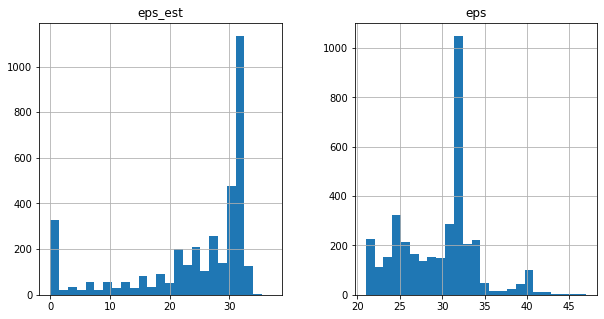

In [14]:
earnings_groupped_df=earnings_limited_df.groupby("symbol").count()
earnings_groupped_df[["eps_est","eps"]].hist(bins=25, figsize=(10,5))
plt.show()

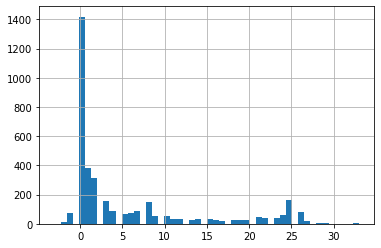

In [15]:
earnings_groupped_df["earnings_without_estimate"]=earnings_groupped_df["eps"]-earnings_groupped_df["eps_est"]
earnings_groupped_df["earnings_without_estimate"].hist(bins=50)

In [16]:
print("total nr of earnings:",earnings_groupped_df["eps"].sum())
print("total nr of earnings estimate:",earnings_groupped_df["eps_est"].sum())
print("total nr of earnings WITHOUT estimate:",earnings_groupped_df["eps"].sum()-earnings_groupped_df["eps_est"].sum())


total nr of earnings: 109782
total nr of earnings estimate: 88767
total nr of earnings WITHOUT estimate: 21015


In [17]:
#double check
cleaned_earnings=earnings_limited_df[earnings_limited_df["eps"].notnull()].copy()
len(cleaned_earnings)

109782

In [18]:
symbols=cleaned_earnings["symbol"].unique()


## Stockprice part
Filtering down the sotck_pricedf to reduce the time for the join

In [19]:
print("stock price original nr. rows",len(stock_pricedf))
stock_price_filtered_df=stock_pricedf[stock_pricedf["symbol"].isin(symbols)].copy()
print("stock price filtered nr. rows",len(stock_price_filtered_df))

stock price original nr. rows 22824533
stock price filtered nr. rows 15983958


In [20]:
stock_price_filtered_df["parsed_date"]=pd.to_datetime(stock_price_filtered_df["date"], format="%Y-%m-%d")
stock_price_filtered_df["date"]=stock_price_filtered_df["parsed_date"]
stock_price_filtered_df=stock_price_filtered_df.sort_values(["symbol","parsed_date"])
stock_price_filtered_df.set_index("parsed_date", inplace=True)

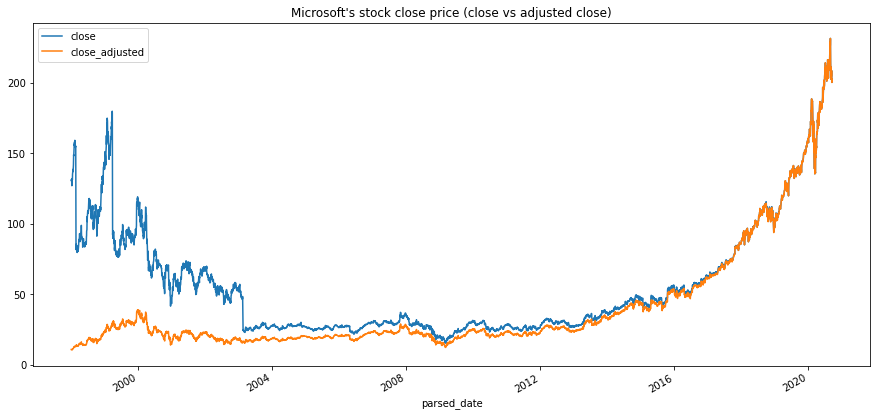

In [21]:

stock_example="MSFT"
stock_price_filtered_df[stock_price_filtered_df["symbol"]==stock_example][["close","close_adjusted"]].plot(title=stock_example,figsize=(15,7))
plt.title("Microsoft's stock close price (close vs adjusted close)")
plt.show()

In [22]:
shift_days=1

stock_price_filtered_df['pct_gain']=stock_price_filtered_df['close_adjusted'].pct_change(shift_days)*100*(shift_days)
stock_price_filtered_df['prev_symbol']=stock_price_filtered_df['symbol'].shift(shift_days)
stock_price_filtered_df

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient,pct_gain,prev_symbol
parsed_date,,,,,,,,,,,
1999-11-18,A,1999-11-18,45.50,50.000,40.00,44.00,29.6303,44739900,1.0,NaN,NaN
1999-11-19,A,1999-11-19,42.94,43.000,39.81,40.38,27.1926,10897100,1.0,-8.227051,A
1999-11-22,A,1999-11-22,41.31,44.000,40.06,44.00,29.6303,4705200,1.0,8.964571,A
1999-11-23,A,1999-11-23,42.50,43.630,40.25,40.25,27.1050,4274400,1.0,-8.522695,A
1999-11-24,A,1999-11-24,40.13,41.940,40.00,41.06,27.6505,3464400,1.0,2.012544,A
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-22,ZYNE,2019-11-22,6.74,6.808,6.18,6.31,6.3100,448683,1.0,-6.240713,ZYNE
2019-11-25,ZYNE,2019-11-25,6.27,6.640,6.25,6.55,6.5500,422413,1.0,3.803487,ZYNE
2019-11-26,ZYNE,2019-11-26,6.51,6.690,6.28,6.52,6.5200,313065,1.0,-0.458015,ZYNE


In [23]:

cleaned_earnings["parsed_date"]=pd.to_datetime(cleaned_earnings["date"], format="%Y-%m-%d")
def effect_on_date(row):
  if row["release_time"]=="pre": 
    return row["parsed_date"] + pd.offsets.Day(0)
  else:
    return row["parsed_date"] + pd.offsets.Day(1)

cleaned_earnings["effect_on_date"]=cleaned_earnings.apply(lambda row: effect_on_date(row), axis = 1)

In [24]:
cleaned_earnings

,symbol,date,qtr,eps_est,eps,release_time,parsed_date,effect_on_date
14,A,2012-11-19,10/2012,0.800,0.84,post,2012-11-19,2012-11-20
15,A,2013-02-14,01/2013,0.660,0.63,post,2013-02-14,2013-02-15
16,A,2013-05-14,04/2013,0.670,0.77,post,2013-05-14,2013-05-15
17,A,2013-08-14,07/2013,0.620,0.68,post,2013-08-14,2013-08-15
18,A,2013-11-14,10/2013,0.760,0.81,post,2013-11-14,2013-11-15
...,...,...,...,...,...,...,...,...
157345,ZYNE,2019-08-06,Q2,-0.497,-0.50,pre,2019-08-06,2019-08-06
157346,ZYNE,2019-11-06,Q3,-0.521,-0.08,pre,2019-11-06,2019-11-06
157347,ZYNE,2020-03-10,Q4,-0.503,-0.46,pre,2020-03-10,2020-03-10
157348,ZYNE,2020-05-11,Q1,-0.497,-0.53,pre,2020-05-11,2020-05-11


In [25]:
stock_price_filtered_df

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient,pct_gain,prev_symbol
parsed_date,,,,,,,,,,,
1999-11-18,A,1999-11-18,45.50,50.000,40.00,44.00,29.6303,44739900,1.0,NaN,NaN
1999-11-19,A,1999-11-19,42.94,43.000,39.81,40.38,27.1926,10897100,1.0,-8.227051,A
1999-11-22,A,1999-11-22,41.31,44.000,40.06,44.00,29.6303,4705200,1.0,8.964571,A
1999-11-23,A,1999-11-23,42.50,43.630,40.25,40.25,27.1050,4274400,1.0,-8.522695,A
1999-11-24,A,1999-11-24,40.13,41.940,40.00,41.06,27.6505,3464400,1.0,2.012544,A
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-22,ZYNE,2019-11-22,6.74,6.808,6.18,6.31,6.3100,448683,1.0,-6.240713,ZYNE
2019-11-25,ZYNE,2019-11-25,6.27,6.640,6.25,6.55,6.5500,422413,1.0,3.803487,ZYNE
2019-11-26,ZYNE,2019-11-26,6.51,6.690,6.28,6.52,6.5200,313065,1.0,-0.458015,ZYNE


In [26]:
df_joined=pd.merge(cleaned_earnings,stock_price_filtered_df,left_on=["symbol","effect_on_date"],right_on=["symbol","date"],how="left")
df_joined

,symbol,date_x,qtr,eps_est,eps,release_time,parsed_date,effect_on_date,date_y,open,high,low,close,close_adjusted,volume,split_coefficient,pct_gain,prev_symbol
0,A,2012-11-19,10/2012,0.800,0.84,post,2012-11-19,2012-11-20,2012-11-20,35.94,36.92,35.8000,36.28,24.8427,10520700.0,1.0,-3.279346,A
1,A,2013-02-14,01/2013,0.660,0.63,post,2013-02-14,2013-02-15,2013-02-15,43.48,44.24,42.2100,42.25,29.0019,14656600.0,1.0,-5.226575,A
2,A,2013-05-14,04/2013,0.670,0.77,post,2013-05-14,2013-05-15,2013-05-15,44.90,46.49,44.8900,45.68,31.4460,10289000.0,1.0,3.889153,A
3,A,2013-08-14,07/2013,0.620,0.68,post,2013-08-14,2013-08-15,2013-08-15,47.59,48.17,46.8500,46.96,32.4179,6708300.0,1.0,0.967696,A
4,A,2013-11-14,10/2013,0.760,0.81,post,2013-11-14,2013-11-15,2013-11-15,54.03,55.74,53.6902,54.93,38.0079,11014300.0,1.0,8.686228,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109777,ZYNE,2019-08-06,Q2,-0.497,-0.50,pre,2019-08-06,2019-08-06,2019-08-06,9.96,10.44,9.7300,10.31,10.3100,929400.0,1.0,5.311542,ZYNE
109778,ZYNE,2019-11-06,Q3,-0.521,-0.08,pre,2019-11-06,2019-11-06,2019-11-06,7.18,7.20,6.6000,6.74,6.7400,626006.0,1.0,-5.469846,ZYNE
109779,ZYNE,2020-03-10,Q4,-0.503,-0.46,pre,2020-03-10,2020-03-10,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109780,ZYNE,2020-05-11,Q1,-0.497,-0.53,pre,2020-05-11,2020-05-11,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_joined=df_joined[df_joined["symbol"]==df_joined["prev_symbol"]]

In [28]:
df_joined.to_pickle("./joined_earnings_prise_chg.pkl")


In [29]:

df_joined_cleaned=df_joined[["symbol","qtr","eps_est","eps","effect_on_date","pct_gain"]].copy()
df_joined_cleaned=df_joined_cleaned.dropna()
df_joined_cleaned["change_direction"] = df_joined_cleaned["pct_gain"].apply(lambda x: 1 if (x>0) else 0)
df_joined_cleaned=df_joined_cleaned.sort_values(["symbol","effect_on_date"])



## Data is Cleaned

In [30]:
df_joined_cleaned

,symbol,qtr,eps_est,eps,effect_on_date,pct_gain,change_direction
0,A,10/2012,0.800,0.84,2012-11-20,-3.279346,0
1,A,01/2013,0.660,0.63,2013-02-15,-5.226575,0
2,A,04/2013,0.670,0.77,2013-05-15,3.889153,1
3,A,07/2013,0.620,0.68,2013-08-15,0.967696,1
4,A,10/2013,0.760,0.81,2013-11-15,8.686228,1
...,...,...,...,...,...,...,...
109774,ZYNE,09/2018,-0.690,-0.47,2018-11-09,-6.885759,0
109775,ZYNE,Q4,-0.646,-0.44,2019-03-12,5.144033,1
109776,ZYNE,Q1,-0.488,-0.47,2019-05-09,-2.207686,0
109777,ZYNE,Q2,-0.497,-0.50,2019-08-06,5.311542,1


Double Check effect date and % gain

In [31]:
df_joined_cleaned[(df_joined_cleaned["symbol"]=="MSFT") & (df_joined_cleaned["pct_gain"]>10)]

,symbol,qtr,eps_est,eps,effect_on_date,pct_gain,change_direction
66040,MSFT,03/2015,0.51,0.62,2015-04-24,10.452324,1
66042,MSFT,09/2015,0.57,0.67,2015-10-23,10.077202,1


## Double check price gain on Yahoo finance
<img src=" https://drive.google.com/uc?id=1vv7SCaCv7j_aWtAaULaDFPI_t6BPUoKY">

In [32]:
df_joined_cleaned["eps_surprise"]=df_joined_cleaned["eps"]-df_joined_cleaned["eps_est"]
df_joined_cleaned=df_joined_cleaned[['symbol', 'qtr', 'eps_est', 'eps', 'effect_on_date','eps_surprise', 'pct_gain','change_direction']]
df_joined_cleaned

,symbol,qtr,eps_est,eps,effect_on_date,eps_surprise,pct_gain,change_direction
0,A,10/2012,0.800,0.84,2012-11-20,0.040,-3.279346,0
1,A,01/2013,0.660,0.63,2013-02-15,-0.030,-5.226575,0
2,A,04/2013,0.670,0.77,2013-05-15,0.100,3.889153,1
3,A,07/2013,0.620,0.68,2013-08-15,0.060,0.967696,1
4,A,10/2013,0.760,0.81,2013-11-15,0.050,8.686228,1
...,...,...,...,...,...,...,...,...
109774,ZYNE,09/2018,-0.690,-0.47,2018-11-09,0.220,-6.885759,0
109775,ZYNE,Q4,-0.646,-0.44,2019-03-12,0.206,5.144033,1
109776,ZYNE,Q1,-0.488,-0.47,2019-05-09,0.018,-2.207686,0
109777,ZYNE,Q2,-0.497,-0.50,2019-08-06,-0.003,5.311542,1


See different kind of corelations: https://easystats.github.io/correlation/articles/types.html

In [33]:

df_joined_cleaned.corr("spearman")

,eps_est,eps,eps_surprise,pct_gain,change_direction
eps_est,1.000000,0.941159,0.117728,0.031950,0.039070
eps,0.941159,1.000000,0.336768,0.091272,0.087321
eps_surprise,0.117728,0.336768,1.000000,0.288329,0.241167
pct_gain,0.031950,0.091272,0.288329,1.000000,0.866026
change_direction,0.039070,0.087321,0.241167,0.866026,1.000000


Lets take one company called Carmax where the spearman corelation is high. 

In [34]:

plotdf=df_joined_cleaned[df_joined_cleaned["symbol"]=="KMX"].copy()
plotdf.set_index("effect_on_date",inplace=True)
plotdf.head(10)

,symbol,qtr,eps_est,eps,eps_surprise,pct_gain,change_direction
effect_on_date,,,,,,,
2012-09-20,KMX,08/2012,0.52,0.48,-0.04,-6.287144,0
2012-12-20,KMX,11/2012,0.39,0.41,0.02,8.983927,1
2013-04-10,KMX,02/2013,0.46,0.46,0.00,3.910749,1
2013-06-21,KMX,05/2013,0.57,0.64,0.07,0.044873,1
2013-09-24,KMX,08/2013,0.57,0.62,0.05,3.559288,1
2013-12-20,KMX,11/2013,0.48,0.47,-0.01,-9.368520,0
2014-04-04,KMX,02/2014,0.53,0.52,-0.01,-4.205214,0
2014-06-20,KMX,05/2014,0.66,0.76,0.10,16.497350,1
2014-09-23,KMX,08/2014,0.67,0.64,-0.03,-9.486840,0


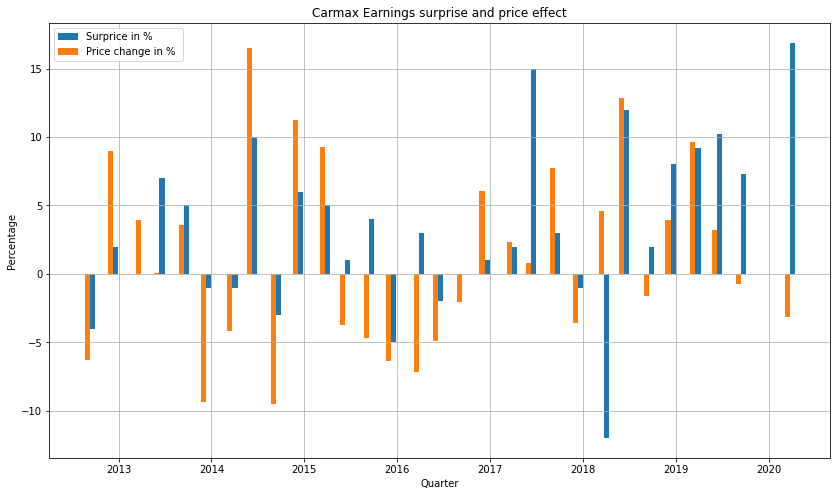

In [35]:


plt.figure(figsize=(14,8))
plt.title("Carmax Earnings surprise and price effect")
plt.bar(plotdf.index,plotdf["eps_surprise"]*100,width=20,label="Surprice in %")
plt.bar(plotdf.index+pd.DateOffset(-20),plotdf["pct_gain"],width=20,label="Price change in % ")
plt.ylabel("Percentage")
plt.xlabel("Quarter")
plt.legend()

plt.grid()

In [36]:
plotdf.corr("spearman")

,eps_est,eps,eps_surprise,pct_gain,change_direction
eps_est,1.000000,0.981080,0.448787,0.110147,-0.034745
eps,0.981080,1.000000,0.552834,0.150662,-0.007722
eps_surprise,0.448787,0.552834,1.000000,0.529163,0.455752
pct_gain,0.110147,0.150662,0.529163,1.000000,0.864579
change_direction,-0.034745,-0.007722,0.455752,0.864579,1.000000


# Baseline Classifiers
## Generate train, valid, test sets
Lets assume we have the info about the EPS in advance, and try to predict the stock price movement direction. (In real life we do not have the EPS in advance , only after earnings report release)

In [38]:


def get_ML_data(df_joined_cleaned,cols=["eps_est","eps","eps_surprise"],train_size_ratio=-1, train_nr_companies=-1):
  if (train_nr_companies>0) and (train_size_ratio > 0):
    raise Exception("you have to chose which do you want: either limiting train_nr_companies or train_size_ratio")
  if (train_size_ratio==-1) and (train_nr_companies==-1):
    train_size_ratio=0.9
  

  if train_size_ratio>0:
    X=df_joined_cleaned[cols]
    y=df_joined_cleaned[["change_direction"]]
    X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=1-train_size_ratio, shuffle=True, random_state = 12)
    X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5, shuffle=True, random_state = 42)
  else:
    if "symbol" not in cols:
      cols.append("symbol")
      cols.append("change_direction")
    #print(cols)
    X=df_joined_cleaned[cols].copy()
    #display(X)
    symbol_list=X["symbol"].unique().tolist()
    #print(type(symbol_list))
    
    random.seed(SEED)
    company_filter=random.sample(symbol_list, train_nr_companies)
    #print(company_filter)
    X_train=X[X["symbol"].isin(company_filter)].copy()
    X_hold=X[~ X["symbol"].isin(company_filter)].copy()
    y_train=X_train.pop("change_direction")
    y_hold=X_hold.pop("change_direction")
    y=X.pop("change_direction")

    X_train.drop("symbol",axis=1,inplace=True)
    X_hold.drop("symbol",axis=1,inplace=True)
    X.drop("symbol",axis=1,inplace=True)

    #y=df_joined_cleaned[["change_direction"]]
    #X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 12)

    X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5, shuffle=True, random_state = 42)


  return X, y, X_train, y_train, X_valid, X_test, y_valid, y_test

X, y, X_train, y_train, X_valid, X_test, y_valid, y_test = get_ML_data(df_joined_cleaned,train_size_ratio=0.9)
print(len(X_train))
print(len(X_valid))
print(len(X_test))
display(X_train.head())

76537
4252
4253


,eps_est,eps,eps_surprise
67516,0.270,0.33,0.060
96920,-0.370,-0.44,-0.070
25805,-0.033,0.02,0.053
74099,0.470,0.42,-0.050
27224,0.308,0.18,-0.128


## Classifiers: Decition Tree and XGBoost
In order to analyse our algorithms we will use a very simple and a more complex classifier. To goal is not to have a fine tuned model which can perform very well now, but rather to see the effect the datascience tricks we apply.

#### We will use f1 score as a metric
https://en.wikipedia.org/wiki/F-score

#### Note:
It is obvious, that the dataset contains "mini" timeseries data for each company, however we will not handle the data as time series manner, rather just as individual points. 

##Dummy Classifier

In [39]:
dc = DummyClassifier(strategy = "most_frequent")
dc.fit(X_train, y_train)
def calculate_metrics(fitted_model,X_valid,y_valid,verbose=True):
  f1_valid = f1_score(y_valid.values, fitted_model.predict(X_valid), average="weighted")
  if verbose:
    print("F1 from f1_score:", f1_valid)
    print(classification_report(y_valid, fitted_model.predict(X_valid)))
  return f1_valid

calculate_metrics(dc,X_valid,y_valid)

F1 from f1_score: 0.3213827063062442
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2172
           1       0.49      1.00      0.66      2080

    accuracy                           0.49      4252
   macro avg       0.24      0.50      0.33      4252
weighted avg       0.24      0.49      0.32      4252



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3213827063062442

## Simple Decision Tree Classifier

F1 from f1_score: 0.6000359491968515
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      2172
           1       0.58      0.64      0.61      2080

    accuracy                           0.60      4252
   macro avg       0.60      0.60      0.60      4252
weighted avg       0.60      0.60      0.60      4252



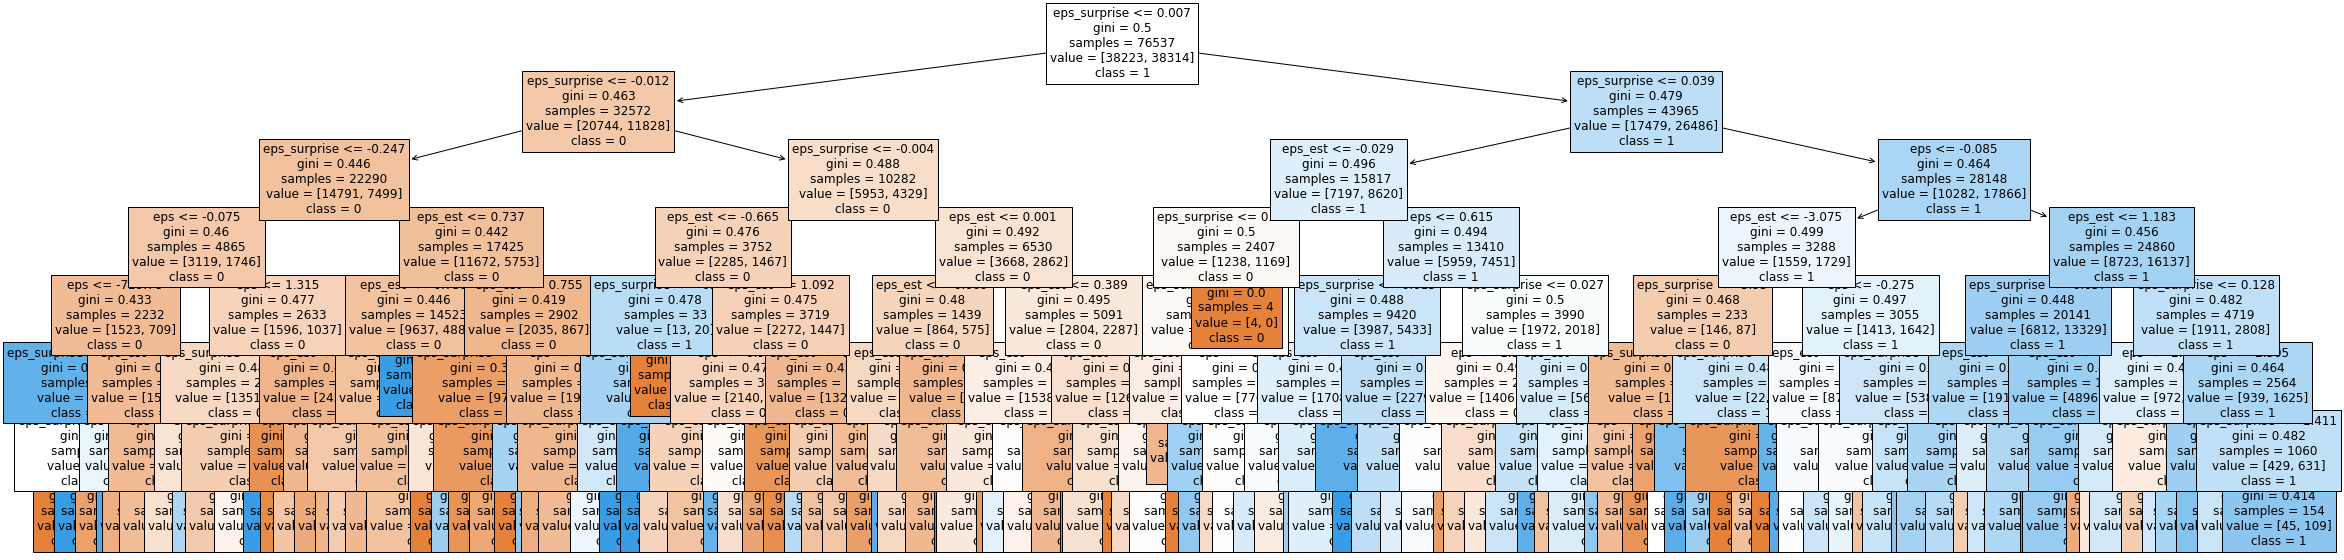

In [40]:

def run_DecisionTree(X_train, y_train,X_valid,y_valid,verbose=True):
  dt = DecisionTreeClassifier(max_depth = 7,random_state=SEED)
  dt.fit(X_train, y_train)
  result=calculate_metrics(dt,X_valid,y_valid,verbose=verbose)
  return result,dt

result_DT_full_ds,dt=run_DecisionTree(X_train, y_train,X_valid,y_valid,verbose=True)

fig = plt.figure(figsize=(40,10))
_ = plot_tree(dt, 
              feature_names=X_train.columns,  
              class_names=[str(i) for i in dt.classes_],
              filled=True,
              fontsize=12)

In [41]:

def run_XGBoost(X_train, y_train,X_valid,y_valid,verbose=True):
  xgb_model=XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=200,n_jobs=2,random_state=SEED)
  xgb_model.fit(X_train, y_train)
  result=calculate_metrics(xgb_model,X_valid,y_valid,verbose=verbose)
  return result,xgb_model

result_XGB_full_ds,xgb_model=run_XGBoost(X_train, y_train,X_valid,y_valid,verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 from f1_score: 0.6077140169332079
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      2172
           1       0.59      0.62      0.61      2080

    accuracy                           0.61      4252
   macro avg       0.61      0.61      0.61      4252
weighted avg       0.61      0.61      0.61      4252



# What is small?

Lets decide how small the data set should be in order to simulate small data. We will analyse XGBoost performance in the range of 1-300 companies.  

In [42]:
dt_metrics=pd.DataFrame()
#for size_ratio in tqdm(train_size_list):
for size_ratio in tqdm(range(1,300+1,3)):

  
  X, y, X_train, y_train, X_valid, X_test, y_valid, y_test = get_ML_data(df_joined_cleaned,train_nr_companies=size_ratio+1)
  result,xgb_model=run_XGBoost(X_train, y_train,X_valid,y_valid,verbose=False)
  
  dt_metrics.at[len(X_train),"size_ratio"]=size_ratio
  dt_metrics.at[len(X_train),"f1"]=result



100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


In [43]:
dt_metrics.set_index("size_ratio", inplace=True)

Text(0, 0.5, 'f1 score')

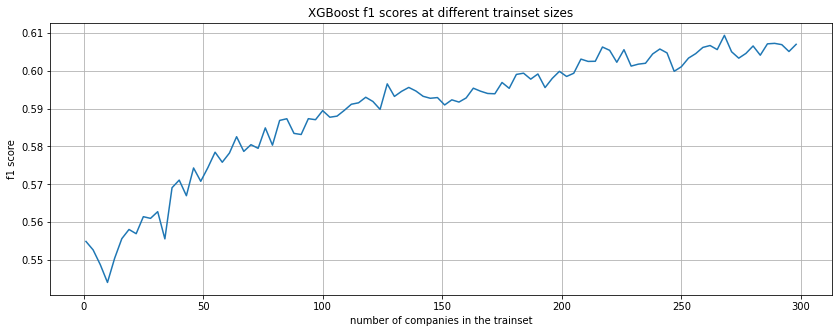

In [44]:

plt.figure(figsize=(14,5))
plt.plot(dt_metrics["f1"])

plt.title("XGBoost f1 scores at different trainset sizes")
plt.xlabel("number of companies in the trainset")
plt.grid()
plt.ylabel("f1 score")

# Run some baseline on just 100 companies

In [45]:
NCOMPANIES=100

In [46]:
X, y, X_train, y_train, X_valid, X_test, y_valid, y_test = get_ML_data(df_joined_cleaned,train_nr_companies=NCOMPANIES)

result_DT_base,dt=run_DecisionTree(X_train, y_train,X_valid,y_valid,verbose=True)

F1 from f1_score: 0.5936697847039574
              precision    recall  f1-score   support

           0       0.60      0.55      0.58     20445
           1       0.59      0.63      0.61     20812

    accuracy                           0.59     41257
   macro avg       0.59      0.59      0.59     41257
weighted avg       0.59      0.59      0.59     41257



In [47]:
X, y, X_train, y_train, X_valid, X_test, y_valid, y_test = get_ML_data(df_joined_cleaned,train_nr_companies=NCOMPANIES)

result_XGB_base,xgb_model=run_XGBoost(X_train, y_train,X_valid,y_valid,verbose=True)

F1 from f1_score: 0.5861832213043507
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     20445
           1       0.59      0.58      0.58     20812

    accuracy                           0.59     41257
   macro avg       0.59      0.59      0.59     41257
weighted avg       0.59      0.59      0.59     41257



# DeltaPY
Let's try Deltapy to introduce some features.

source: https://github.com/firmai/deltapy

In [48]:


from deltapy import transform, interact, mapper, extract 
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Task: Add some transformation

Use different transformations to create new features on a company level time series.
- Create the Fractional Differencing feature on "eps" and "eps_surprise" with a d=0.5
- Use Naive Decomposition on "eps" and "eps_surprise" , with freqvency of 4
- Add multiple lags feature with start of 1 and end of 4 for columns "eps", "eps_surprise", "change_direction" .

In [49]:
symbol_list=df_joined_cleaned["symbol"].unique()
random.seed(SEED)
symbol_list=random.sample(symbol_list.tolist(),NCOMPANIES*4)
result_dfs=list()

for stocksymbol in tqdm(symbol_list):
  one_stockdf=df_joined_cleaned[df_joined_cleaned["symbol"]==stocksymbol]

  try:
    #TASK Use different transformations to create new features on a company level time series


    # Create the Fractional Differencing feature on "eps" and "eps_surprise" with a d=0.5
    one_stockdf= transform.fast_fracdiff(one_stockdf.copy(), ["eps","eps_surprise"],0.5)
    
    # Use Naive Decomposition on "eps" and "eps_surprise" , with freqvency of 4
    one_stockdf= transform.naive_dec(one_stockdf.copy(), ["eps","eps_surprise"], freq=4)
    
    # Add multiple lags feature with start of 1 and end of 4 for columns "eps","eps_surprise","change_direction" .
    one_stockdf= transform.multiple_lags(one_stockdf, start=1, end=4, columns=["eps","eps_surprise","change_direction"])
    
    # Add any other trick you'd like
    #one_stockdf= 

  except:
      print("error")
      pass
  
  result_dfs.append(one_stockdf)
  

 16%|█▌        | 64/400 [00:01<00:06, 54.38it/s]

error
error


 19%|█▉        | 76/400 [00:01<00:05, 54.26it/s]

error


 28%|██▊       | 112/400 [00:02<00:05, 52.74it/s]

error
error


 36%|███▌      | 142/400 [00:02<00:04, 54.04it/s]

error


 55%|█████▌    | 220/400 [00:04<00:03, 54.20it/s]

error
error


 60%|█████▉    | 238/400 [00:04<00:03, 53.32it/s]

error


 86%|████████▋ | 346/400 [00:06<00:00, 54.04it/s]

error


100%|██████████| 400/400 [00:07<00:00, 52.76it/s]


In [50]:
df_joined_with_new_features=pd.concat(result_dfs)
df_joined_with_new_features

,symbol,qtr,eps_est,eps,effect_on_date,eps_surprise,pct_gain,change_direction,eps_frac,eps_surprise_frac,eps_NDDT,eps_NDDS,eps_NDDR,eps_surprise_NDDT,eps_surprise_NDDS,eps_surprise_NDDR,eps_t_1,eps_surprise_t_1,change_direction_t_1,eps_t_2,eps_surprise_t_2,change_direction_t_2,eps_t_3,eps_surprise_t_3,change_direction_t_3,eps_t_4,eps_surprise_t_4,change_direction_t_4
85327,RY,10/2012,1.270,1.26,2012-11-29,-0.010,0.289068,1,1.260000,-0.010000,NaN,-0.003958,NaN,NaN,-0.003340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85328,RY,01/2013,1.340,1.33,2013-02-28,-0.010,0.112891,1,0.700000,-0.005000,NaN,-0.101458,NaN,NaN,-0.066536,NaN,1.26,-0.010,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85329,RY,04/2013,1.280,1.25,2013-05-31,-0.030,-2.558564,0,0.427500,-0.023750,NaN,0.060685,NaN,NaN,0.078589,NaN,1.33,-0.010,1.0,1.26,-0.010,1.0,NaN,NaN,NaN,NaN,NaN,NaN
85330,RY,07/2013,1.330,1.38,2013-08-29,0.050,0.633917,1,0.510000,0.066875,NaN,0.044732,NaN,NaN,-0.008712,NaN,1.25,-0.030,0.0,1.33,-0.010,1.0,1.26,-0.010,1.0,NaN,NaN,NaN
85331,RY,10/2013,1.350,1.31,2013-12-05,-0.040,-0.882158,0,0.331406,-0.060234,1.31125,-0.003958,0.002708,-0.003750,-0.003340,-0.032910,1.38,0.050,1.0,1.25,-0.030,0.0,1.33,-0.010,1.0,1.26,-0.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39918,FOR,06/2019,0.060,0.16,2019-07-26,0.100,3.200000,1,-0.097430,0.003395,0.34250,-0.116562,-0.065938,0.003750,-0.042825,0.139075,0.24,0.110,1.0,0.58,0.480,0.0,0.27,-0.800,0.0,0.40,0.35,1.0
39919,FOR,Q4,0.086,0.29,2019-11-08,0.204,3.457447,1,0.096522,0.118276,0.31500,0.106438,-0.131438,0.098000,-0.110250,0.216250,0.16,0.100,1.0,0.24,0.110,1.0,0.58,0.480,0.0,0.27,-0.80,0.0
39920,FOR,Q1,0.130,0.35,2020-01-24,0.220,-0.402865,0,0.110503,0.083657,0.28875,-0.081563,0.142812,0.191000,0.001600,0.027400,0.29,0.204,1.0,0.16,0.100,1.0,0.24,0.110,1.0,0.58,0.48,0.0
39921,FOR,Q2,0.155,0.20,2020-04-24,0.045,-4.234528,0,-0.076504,-0.112436,0.25500,0.091687,-0.146687,0.150375,0.151475,-0.256850,0.35,0.220,0.0,0.29,0.204,1.0,0.16,0.100,1.0,0.24,0.11,1.0


In [51]:
df_joined_with_new_features.describe()

,eps_est,eps,eps_surprise,pct_gain,change_direction,eps_frac,eps_surprise_frac,eps_NDDT,eps_NDDS,eps_NDDR,eps_surprise_NDDT,eps_surprise_NDDS,eps_surprise_NDDR,eps_t_1,eps_surprise_t_1,change_direction_t_1,eps_t_2,eps_surprise_t_2,change_direction_t_2,eps_t_3,eps_surprise_t_3,change_direction_t_3,eps_t_4,eps_surprise_t_4,change_direction_t_4
count,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,8417.000000,9921.000000,8397.000000,8417.000000,9921.000000,8397.000000,9587.000000,9587.000000,9587.000000,9197.000000,9197.000000,9197.000000,8807.000000,8807.000000,8807.000000,8417.000000,8417.000000,8417.000000
mean,0.178300,0.282273,0.103973,0.142267,0.502401,0.071090,0.023427,0.317129,-0.007299,0.178813,0.112008,0.022732,-0.003087,0.288435,0.110438,0.502764,0.285291,0.116391,0.503208,0.270277,0.121449,0.504826,0.253464,0.125817,0.506237
std,22.375875,23.282772,26.895793,14.761737,0.500019,23.821746,30.241017,12.152871,9.650756,23.078245,10.389701,8.937085,29.599858,23.760956,27.459687,0.500018,24.256047,28.035523,0.500017,24.783656,28.649081,0.500005,25.346412,29.304851,0.499991
min,-987.540000,-987.540000,-1481.310000,-68.506998,0.000000,-1049.886250,-1587.168490,-431.673750,-204.386536,-860.492526,-246.760000,-220.085078,-1322.946172,-987.540000,-1481.310000,0.000000,-987.540000,-1481.310000,0.000000,-987.540000,-1481.310000,0.000000,-987.540000,-1481.310000,0.000000
25%,0.010000,0.010000,-0.030000,-3.210091,0.000000,-0.041865,-0.043780,0.032500,-0.052375,-0.070714,-0.011250,-0.026789,-0.049578,0.010000,-0.029000,0.000000,0.020000,-0.020000,0.000000,0.020000,-0.020000,0.000000,0.020000,-0.020000,0.000000
50%,0.300000,0.300000,0.020000,0.040565,1.000000,0.063988,0.002768,0.333750,-0.000703,0.011339,0.017500,0.000446,0.000487,0.310000,0.015000,1.000000,0.310000,0.017000,1.000000,0.310000,0.020000,1.000000,0.310000,0.020000,1.000000
75%,0.640000,0.680000,0.070000,3.242230,1.000000,0.216361,0.054964,0.685000,0.053437,0.100893,0.057500,0.028059,0.053848,0.690000,0.070000,1.000000,0.690000,0.070000,1.000000,0.680000,0.070000,1.000000,0.680000,0.070000,1.000000
max,987.540000,987.540000,987.540000,1254.024557,1.000000,1158.622148,1343.795664,555.616250,320.275339,1037.217161,493.895000,212.328255,1207.125078,987.540000,987.540000,1.000000,987.540000,987.540000,1.000000,987.540000,987.540000,1.000000,987.540000,987.540000,1.000000


In [52]:

df_joined_with_new_features=df_joined_with_new_features.dropna()
len(df_joined_with_new_features)

8397

In [53]:
cols_to_use=df_joined_with_new_features.columns.values
cols_to_use=cols_to_use.tolist()
cols_to_use.remove("symbol")
cols_to_use.remove("qtr")
cols_to_use.remove("effect_on_date")
cols_to_use.remove("pct_gain")
cols_to_use.remove("change_direction")
cols_to_use

['eps_est',
 'eps',
 'eps_surprise',
 'eps_frac',
 'eps_surprise_frac',
 'eps_NDDT',
 'eps_NDDS',
 'eps_NDDR',
 'eps_surprise_NDDT',
 'eps_surprise_NDDS',
 'eps_surprise_NDDR',
 'eps_t_1',
 'eps_surprise_t_1',
 'change_direction_t_1',
 'eps_t_2',
 'eps_surprise_t_2',
 'change_direction_t_2',
 'eps_t_3',
 'eps_surprise_t_3',
 'change_direction_t_3',
 'eps_t_4',
 'eps_surprise_t_4',
 'change_direction_t_4']

In [54]:
df_joined_with_new_features.corr("spearman")

,eps_est,eps,eps_surprise,pct_gain,change_direction,eps_frac,eps_surprise_frac,eps_NDDT,eps_NDDS,eps_NDDR,eps_surprise_NDDT,eps_surprise_NDDS,eps_surprise_NDDR,eps_t_1,eps_surprise_t_1,change_direction_t_1,eps_t_2,eps_surprise_t_2,change_direction_t_2,eps_t_3,eps_surprise_t_3,change_direction_t_3,eps_t_4,eps_surprise_t_4,change_direction_t_4
eps_est,1.000000,0.944207,0.120609,0.016043,0.028149,0.539713,-0.026322,0.897324,0.111892,0.196762,0.239475,-0.018730,-0.028149,0.846904,0.160100,0.058070,0.806018,0.170816,0.051776,0.818616,0.165027,0.050878,0.852557,0.182124,0.061661
eps,0.944207,1.000000,0.335850,0.081500,0.083414,0.634278,0.153171,0.889542,0.144089,0.291424,0.344107,0.050744,0.116672,0.835198,0.217311,0.072257,0.790681,0.208242,0.052116,0.798218,0.201967,0.055030,0.832545,0.215616,0.062264
eps_surprise,0.120609,0.335850,1.000000,0.298544,0.251046,0.435374,0.735142,0.200109,0.111960,0.390747,0.459790,0.235442,0.541620,0.174903,0.256106,0.055034,0.166908,0.218076,0.014809,0.154497,0.193145,0.029702,0.154951,0.197529,0.033379
pct_gain,0.016043,0.081500,0.298544,1.000000,0.865965,0.148491,0.304688,0.025253,0.037129,0.160938,0.045758,0.061516,0.252603,0.013875,-0.016761,-0.010133,0.012937,-0.009790,0.001491,0.012635,0.002524,0.007382,0.015479,-0.009343,0.008304
change_direction,0.028149,0.083414,0.251046,0.865965,1.000000,0.128661,0.258345,0.035481,0.033341,0.138899,0.035403,0.049896,0.217238,0.028265,-0.010869,-0.013819,0.023338,-0.009547,0.002603,0.022907,0.004337,-0.003136,0.025393,-0.010279,0.010691
eps_frac,0.539713,0.634278,0.435374,0.148491,0.128661,1.000000,0.407852,0.354393,0.374807,0.602323,0.181908,0.151541,0.299861,0.272864,0.045179,0.047846,0.264469,0.083665,0.022625,0.323273,0.084049,0.028735,0.378398,0.129272,0.042766
eps_surprise_frac,-0.026322,0.153171,0.735142,0.304688,0.258345,0.407852,1.000000,-0.002016,0.130894,0.366980,-0.013624,0.291615,0.696944,-0.064503,-0.243276,-0.067590,-0.011912,-0.069387,-0.031871,-0.007355,-0.023036,0.013980,0.009113,0.002929,-0.000395
eps_NDDT,0.897324,0.889542,0.200109,0.025253,0.035481,0.354393,-0.002016,1.000000,-0.022364,0.044322,0.359671,-0.015590,-0.026219,0.926138,0.230189,0.048905,0.929352,0.248609,0.056120,0.923465,0.256537,0.065541,0.895048,0.242245,0.068207
eps_NDDS,0.111892,0.144089,0.111960,0.037129,0.033341,0.374807,0.130894,-0.022364,1.000000,-0.158926,0.009132,0.477174,-0.122356,-0.033987,-0.014870,0.000464,-0.115612,-0.040606,-0.018207,-0.047467,-0.056068,-0.027927,0.111394,0.080415,0.031742
eps_NDDR,0.196762,0.291424,0.390747,0.160938,0.138899,0.602323,0.366980,0.044322,-0.158926,1.000000,0.089539,-0.127132,0.516825,0.059768,0.069485,0.067897,-0.005250,0.022036,0.026963,-0.019020,-0.012224,0.016004,-0.008696,-0.025670,-0.011702


In [55]:

X, y, X_train, y_train, X_valid, X_test, y_valid, y_test = get_ML_data(df_joined_with_new_features,cols=cols_to_use,train_nr_companies=NCOMPANIES)

In [56]:

result_DT_after_feature_eng,dt=run_DecisionTree(X_train, y_train,X_valid,y_valid,verbose=True)


F1 from f1_score: 0.6065309542527691
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      1491
           1       0.60      0.66      0.63      1539

    accuracy                           0.61      3030
   macro avg       0.61      0.61      0.61      3030
weighted avg       0.61      0.61      0.61      3030



In [57]:

result_XGB_after_feature_eng,xgb=run_XGBoost(X_train, y_train,X_valid,y_valid,verbose=True)


F1 from f1_score: 0.602570701729984
              precision    recall  f1-score   support

           0       0.60      0.57      0.59      1491
           1       0.60      0.63      0.62      1539

    accuracy                           0.60      3030
   macro avg       0.60      0.60      0.60      3030
weighted avg       0.60      0.60      0.60      3030



# Synthetic DATA part
## CTGAN
paper: https://arxiv.org/pdf/1907.00503.pdf

How to install and use CTGAN: https://pypi.org/project/ctgan/

In [58]:

Xy_train=X_train.copy()
Xy_train["change_direction"]=y_train
Xy_train

,eps_est,eps,eps_surprise,eps_frac,eps_surprise_frac,eps_NDDT,eps_NDDS,eps_NDDR,eps_surprise_NDDT,eps_surprise_NDDS,eps_surprise_NDDR,eps_t_1,eps_surprise_t_1,change_direction_t_1,eps_t_2,eps_surprise_t_2,change_direction_t_2,eps_t_3,eps_surprise_t_3,change_direction_t_3,eps_t_4,eps_surprise_t_4,change_direction_t_4,change_direction
99017,0.180,0.10,-0.080,0.010547,-0.057031,0.14875,-0.028281,-0.020469,3.469447e-18,-0.028750,-0.051250,0.10,-0.060,1.0,0.17,0.010,0.0,0.21,0.08,1.0,0.13,0.02,0.0,0
99018,0.190,0.20,0.010,0.115117,0.053203,0.14375,0.018594,0.037656,-2.125000e-02,0.021250,0.010000,0.10,-0.080,0.0,0.10,-0.060,1.0,0.17,0.01,0.0,0.21,0.08,1.0,1
99019,0.210,0.16,-0.050,0.026201,-0.044238,0.14125,-0.009531,0.028281,-3.750000e-02,-0.016875,0.004375,0.20,0.010,1.0,0.10,-0.080,0.0,0.10,-0.06,1.0,0.17,0.01,0.0,0
99020,0.210,0.20,-0.010,0.073794,0.018857,0.15250,0.019219,0.028281,-3.875000e-02,0.024375,0.004375,0.16,-0.050,0.0,0.20,0.010,1.0,0.10,-0.08,0.0,0.10,-0.06,1.0,1
99021,0.220,0.23,0.010,0.082287,0.023635,0.18125,-0.028281,0.077031,-2.125000e-02,-0.028750,0.060000,0.20,-0.010,1.0,0.16,-0.050,0.0,0.20,0.01,1.0,0.10,-0.08,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52684,-0.920,-0.59,0.330,0.323474,0.952716,-0.52625,-0.527188,0.463438,-6.337500e-01,-0.686178,1.649928,-1.52,-0.870,0.0,1.07,0.270,1.0,-0.52,-1.39,0.0,-1.68,-1.42,0.0,1
52685,-0.370,-0.26,0.110,0.374356,0.197515,-0.35750,-0.258937,0.356437,-2.275000e-01,-0.079266,0.416766,-0.59,0.330,1.0,-1.52,-0.870,0.0,1.07,0.27,1.0,-0.52,-1.39,0.0,1
52686,0.767,-0.41,-1.177,0.018185,-1.103776,-0.51000,-0.287187,0.387188,-2.208750e-01,-0.396178,-0.559947,-0.26,0.110,1.0,-0.59,0.330,1.0,-1.52,-0.87,0.0,1.07,0.27,1.0,0
52687,-0.617,0.21,0.827,0.654674,1.510484,-0.47875,1.073312,-0.384562,-1.896250e-01,1.161622,-0.144997,-0.41,-1.177,0.0,-0.26,0.110,1.0,-0.59,0.33,1.0,-1.52,-0.87,0.0,1


## Task: use CTGAN
- Collect the discrete columns.
- Create CTGAN Instance 
- fit the model, use 500 Epochs

hint: You can use the docs here: https://pypi.org/project/ctgan/


In [59]:
from ctgan import CTGANSynthesizer


#TASK:
# please collect the discrete columns to a list, CTGAN must know about the decrete columns. 
# hint: "change_direction" is a discrete columns since it has only a value of 0 or 1
discrete_columns = ["change_direction","change_direction_t_1","change_direction_t_2","change_direction_t_3","change_direction_t_4"]
# Create the CTGAN instance
ctgan = CTGANSynthesizer()
# fit the model
ctgan.fit(Xy_train,discrete_columns,epochs=500) 



Epoch 1, Loss G: 0.7722, Loss D: -0.0773
Epoch 2, Loss G: 0.7317, Loss D: -0.2414
Epoch 3, Loss G: 0.6668, Loss D: -0.4002
Epoch 4, Loss G: 0.6118, Loss D: -0.5936
Epoch 5, Loss G: 0.5688, Loss D: -0.8964
Epoch 6, Loss G: 0.4568, Loss D: -0.8286
Epoch 7, Loss G: -0.0232, Loss D: -0.2652
Epoch 8, Loss G: -0.4103, Loss D: -0.1261
Epoch 9, Loss G: -0.6653, Loss D: 0.1396
Epoch 10, Loss G: -0.7189, Loss D: 0.0438
Epoch 11, Loss G: -0.7233, Loss D: 0.2629
Epoch 12, Loss G: -0.6165, Loss D: 0.2448
Epoch 13, Loss G: -0.4091, Loss D: -0.0214
Epoch 14, Loss G: -0.1886, Loss D: -0.0488
Epoch 15, Loss G: -0.0093, Loss D: 0.0159
Epoch 16, Loss G: 0.0722, Loss D: 0.0320
Epoch 17, Loss G: 0.2280, Loss D: -0.0091
Epoch 18, Loss G: 0.1741, Loss D: 0.1876
Epoch 19, Loss G: 0.1859, Loss D: 0.2429
Epoch 20, Loss G: 0.1317, Loss D: 0.1028
Epoch 21, Loss G: 0.0576, Loss D: 0.2250
Epoch 22, Loss G: -0.0627, Loss D: 0.0026
Epoch 23, Loss G: -0.1153, Loss D: 0.1317
Epoch 24, Loss G: -0.2945, Loss D: 0.1972
Ep

In [60]:
synth_df=ctgan.sample(4000)
synth_df.replace([np.inf, -np.inf], np.nan,inplace=True)
synth_df=synth_df.dropna()
synth_df.describe()

,eps_est,eps,eps_surprise,eps_frac,eps_surprise_frac,eps_NDDT,eps_NDDS,eps_NDDR,eps_surprise_NDDT,eps_surprise_NDDS,eps_surprise_NDDR,eps_t_1,eps_surprise_t_1,change_direction_t_1,eps_t_2,eps_surprise_t_2,change_direction_t_2,eps_t_3,eps_surprise_t_3,change_direction_t_3,eps_t_4,eps_surprise_t_4,change_direction_t_4,change_direction
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.076470,0.987445,0.127568,0.153233,0.052244,1.081493,0.108690,-0.217280,0.046948,-0.049637,0.139474,0.281169,0.161685,0.594250,0.471612,0.179752,0.510750,0.333989,-0.084317,0.517250,0.214741,0.051369,0.583750,0.570000
std,0.946277,1.289302,0.348927,0.650021,0.460838,1.125947,0.329968,0.448151,0.201170,0.189559,0.432051,1.015773,0.405002,0.491098,1.050770,0.405939,0.499947,1.051979,0.422009,0.499765,1.017347,0.357420,0.492998,0.495138
min,-5.290672,-5.312671,-3.185000,-5.211189,-3.807711,-3.149784,-1.933235,-5.044345,-1.986533,-2.025408,-3.874557,-7.893132,-4.073156,0.000000,-3.893927,-3.484782,0.000000,-5.568606,-4.613063,0.000000,-6.255789,-3.059413,0.000000,0.000000
25%,-0.432543,0.221025,-0.013608,-0.055031,-0.077934,0.386781,-0.001844,-0.277718,-0.036573,-0.064689,-0.010493,-0.284608,0.000088,0.000000,-0.187202,0.030911,0.000000,-0.306115,-0.125106,0.000000,-0.344828,-0.061484,0.000000,0.000000
50%,-0.013304,0.733548,0.065213,0.105451,0.001345,0.874201,0.069616,-0.168385,0.018638,-0.029168,0.069203,0.198963,0.087149,1.000000,0.327381,0.096051,1.000000,0.152306,-0.059939,1.000000,0.156280,0.019364,1.000000,1.000000
75%,0.521559,1.363181,0.171170,0.284515,0.089041,1.521528,0.136747,-0.048566,0.093153,0.008893,0.153352,0.684887,0.234446,1.000000,0.887780,0.211197,1.000000,0.748847,0.023672,1.000000,0.705775,0.125191,1.000000,1.000000
max,5.470322,9.530482,3.131913,5.469617,3.596996,5.566798,3.049605,2.356677,1.465931,1.383547,6.799267,6.861948,3.219290,1.000000,6.374991,3.182729,1.000000,7.029987,2.412397,1.000000,5.994359,3.014105,1.000000,1.000000


In [61]:
synth_y=synth_df.pop("change_direction")
synth_X=synth_df
synth_X.columns

Index(['eps_est', 'eps', 'eps_surprise', 'eps_frac', 'eps_surprise_frac',
       'eps_NDDT', 'eps_NDDS', 'eps_NDDR', 'eps_surprise_NDDT',
       'eps_surprise_NDDS', 'eps_surprise_NDDR', 'eps_t_1', 'eps_surprise_t_1',
       'change_direction_t_1', 'eps_t_2', 'eps_surprise_t_2',
       'change_direction_t_2', 'eps_t_3', 'eps_surprise_t_3',
       'change_direction_t_3', 'eps_t_4', 'eps_surprise_t_4',
       'change_direction_t_4'],
      dtype='object')

In [62]:
X_valid.describe()

,eps_est,eps,eps_surprise,eps_frac,eps_surprise_frac,eps_NDDT,eps_NDDS,eps_NDDR,eps_surprise_NDDT,eps_surprise_NDDS,eps_surprise_NDDR,eps_t_1,eps_surprise_t_1,change_direction_t_1,eps_t_2,eps_surprise_t_2,change_direction_t_2,eps_t_3,eps_surprise_t_3,change_direction_t_3,eps_t_4,eps_surprise_t_4,change_direction_t_4
count,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000,3030.000000
mean,-0.048504,0.143533,0.192037,-0.159833,0.108496,0.395335,-0.203440,-0.048363,0.323559,0.057609,-0.189132,0.433682,0.028459,0.514191,0.558700,0.356471,0.508251,0.516033,0.701912,0.506601,0.002321,0.222753,0.506601
std,18.331875,9.629198,8.988883,16.145969,6.495116,11.000910,6.136668,16.535587,10.830352,6.127135,7.221247,9.768689,0.753516,0.499881,18.465588,17.954525,0.500014,18.545976,25.352861,0.500039,8.388276,22.796363,0.500039
min,-987.540000,-493.770000,-11.990000,-885.104871,-59.006022,-124.998750,-204.386536,-860.492526,-42.060000,-188.828620,-318.027943,-115.440000,-11.990000,0.000000,-130.430000,-13.490000,0.000000,-130.430000,-13.490000,0.000000,-333.330000,-492.770000,0.000000
25%,0.010000,0.010000,-0.020000,-0.048006,-0.042434,0.027500,-0.058929,-0.068507,-0.013750,-0.027294,-0.045919,0.010000,-0.021500,0.000000,0.020000,-0.030000,0.000000,0.020000,-0.020000,0.000000,0.020000,-0.020000,0.000000
50%,0.320000,0.330000,0.020000,0.056847,0.003679,0.340000,-0.001455,0.012630,0.016250,0.000732,0.002276,0.340000,0.013000,1.000000,0.335000,0.010000,1.000000,0.330000,0.016000,1.000000,0.320000,0.010000,1.000000
75%,0.640000,0.700000,0.070000,0.201007,0.057360,0.673750,0.051704,0.102137,0.053750,0.028729,0.053537,0.710000,0.070000,1.000000,0.690000,0.060000,1.000000,0.670000,0.070000,1.000000,0.670000,0.060000,1.000000
max,32.168000,39.820000,493.770000,39.148833,348.392508,555.616250,5.228698,204.261536,493.895000,196.585443,54.660375,493.770000,22.490000,1.000000,987.540000,987.540000,1.000000,987.540000,987.540000,1.000000,18.430000,984.540000,1.000000


In [63]:
mixed_X=pd.concat([synth_X,X_train])
mixed_y=pd.concat([synth_y,y_train])
run_DecisionTree(mixed_X,mixed_y,X_valid,y_valid,verbose=True)

run_XGBoost(mixed_X,mixed_y,X_valid,y_valid,verbose=True)

F1 from f1_score: 0.6128632049827375
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      1491
           1       0.61      0.67      0.64      1539

    accuracy                           0.61      3030
   macro avg       0.61      0.61      0.61      3030
weighted avg       0.61      0.61      0.61      3030

F1 from f1_score: 0.6189655389641611
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      1491
           1       0.62      0.65      0.64      1539

    accuracy                           0.62      3030
   macro avg       0.62      0.62      0.62      3030
weighted avg       0.62      0.62      0.62      3030



(0.6189655389641611,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimators=200, n_jobs=2,
               nthread=None, objective='binary:logistic', random_state=42,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1))

In [64]:
import numpy as np
N=100
train_size_list=np.logspace(1, 4, N, endpoint=True)*10
train_size_list=np.round(train_size_list)
train_size_list


array([   100.,    107.,    115.,    123.,    132.,    142.,    152.,
          163.,    175.,    187.,    201.,    215.,    231.,    248.,
          266.,    285.,    305.,    327.,    351.,    376.,    404.,
          433.,    464.,    498.,    534.,    572.,    614.,    658.,
          705.,    756.,    811.,    870.,    933.,   1000.,   1072.,
         1150.,   1233.,   1322.,   1417.,   1520.,   1630.,   1748.,
         1874.,   2009.,   2154.,   2310.,   2477.,   2656.,   2848.,
         3054.,   3275.,   3511.,   3765.,   4037.,   4329.,   4642.,
         4977.,   5337.,   5722.,   6136.,   6579.,   7055.,   7565.,
         8111.,   8697.,   9326.,  10000.,  10723.,  11498.,  12328.,
        13219.,  14175.,  15199.,  16298.,  17475.,  18738.,  20092.,
        21544.,  23101.,  24771.,  26561.,  28480.,  30539.,  32745.,
        35112.,  37649.,  40370.,  43288.,  46416.,  49770.,  53367.,
        57224.,  61359.,  65793.,  70548.,  75646.,  81113.,  86975.,
        93260., 1000

In [65]:
dt_metrics=pd.DataFrame()
#for samplesize in range(100,10000,100):
for samplesize in tqdm(train_size_list):
  try:

    samplesize=int(samplesize)
    synth_df=ctgan.sample(samplesize)
    synth_df.replace([np.inf, -np.inf], np.nan,inplace=True)
    synth_df=synth_df.dropna()

    synth_y=synth_df.pop("change_direction")
    synth_X=synth_df

    mixed_X=pd.concat([synth_X,X_train])
    mixed_y=pd.concat([synth_y,y_train])
    result_DT,dt=run_DecisionTree(mixed_X,mixed_y,X_valid,y_valid,verbose=False)

    result_XGB,xgb=run_XGBoost(mixed_X,mixed_y,X_valid,y_valid,verbose=False)
    dt_metrics.at[samplesize,"f1 DT"]=result_DT
    dt_metrics.at[samplesize,"f1 XGBoost"]=result_XGB
    #print(samplesize)
  except:

    pass
  


100%|██████████| 100/100 [14:34<00:00,  8.75s/it]


In [66]:
dt_metrics.head()

,f1 DT,f1 XGBoost
100,0.574710,0.605512
107,0.608544,0.600589
115,0.607574,0.608031
123,0.605632,0.602476
132,0.605288,0.598693


Text(0, 0.5, 'f1 score')

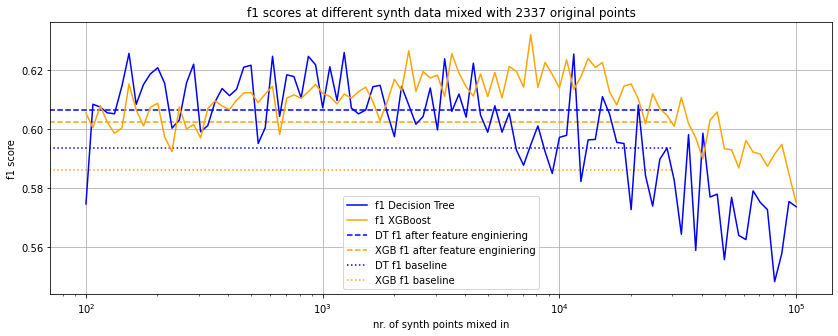

In [67]:
#dt_metrics.set_index("size_ratio", inplace=True)
plt.figure(figsize=(14,5))

plt.plot(dt_metrics["f1 DT"],label="f1 Decision Tree",color='blue')
plt.plot(dt_metrics["f1 XGBoost"],label="f1 XGBoost",color='orange')
#plt.scatter(dt_metrics.index,dt_metrics["size_ratio"])
#plt.scatter(8500,0.607)
plt.hlines(result_DT_after_feature_eng,0,3e4,colors='blue',linestyles='dashed',label="DT f1 after feature enginiering")
plt.hlines(result_XGB_after_feature_eng,0,3e4,colors='orange',linestyles='dashed',label="XGB f1 after feature enginiering")
plt.hlines(result_DT_base,0,3e4,colors='blue',linestyles='dotted',label="DT f1 baseline")
plt.hlines(result_XGB_base,0,3e4,colors='orange',linestyles='dotted',label="XGB f1 baseline")
plt.title("f1 scores at different synth data mixed with {} original points".format(len(X_train)))
plt.xlabel("nr. of synth points mixed in")
plt.legend()
plt.grid()
plt.xscale("log")
plt.ylabel("f1 score")

In [68]:

samplesize=1000
samplesize=int(samplesize)
synth_df=ctgan.sample(samplesize)
synth_df.replace([np.inf, -np.inf], np.nan,inplace=True)
synth_df=synth_df.dropna()

synth_y=synth_df.pop("change_direction")
synth_X=synth_df

mixed_X=pd.concat([synth_X,X_train])
mixed_y=pd.concat([synth_y,y_train])

In [69]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2)
mixed_X_embedded = tsne.fit_transform(mixed_X)

In [70]:
synth_X_length=len(synth_X)
X_train_length=len(X_train)

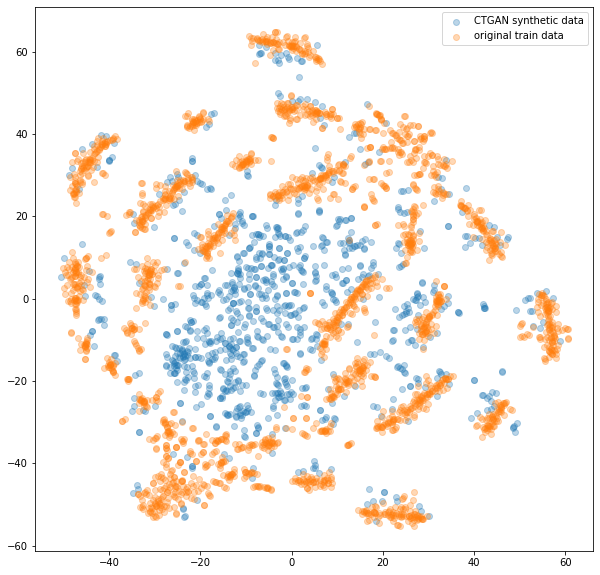

In [71]:
plt.figure(figsize=(10,10))

plt.scatter(mixed_X_embedded[:synth_X_length,0],mixed_X_embedded[:synth_X_length,1],alpha=.3,label="CTGAN synthetic data")
plt.scatter(mixed_X_embedded[synth_X_length:,0],mixed_X_embedded[synth_X_length:,1],alpha=.3,label="original train data")
plt.legend()

# How to deal with imbalanced data?

In [72]:
from imblearn.over_sampling import ADASYN

In [73]:
print("Ratio of class 1 of the dataset: {:.2f} %".format(100*y_train.sum()/len(y_train)))

Ratio of class 1 of the dataset: 51.18 %


This is not imbalanced at all, lets make it imbalanced.

## Task: run ADASYN on imbalanced subset.

- Create the ADASYN instance in the for loop
- fit and resample the downsampled data

In [74]:
dt_metrics=pd.DataFrame()


chosen_majority_class=0
chosen_minority_class=1
label_col_name="change_direction"
for sample_ratio in range(1,49,1):
  try:
    nr_of_minority_class=int(len(Xy_train)*sample_ratio/100)
    Xy_train_downsampled=Xy_train.groupby(label_col_name).apply(lambda x: x.sample(nr_of_minority_class))
    Xy_minority=Xy_train_downsampled[Xy_train_downsampled[label_col_name]==chosen_minority_class]
    Xy_majority=Xy_train[Xy_train[label_col_name]==chosen_majority_class]
    Xy_train_downsampled=pd.concat([Xy_majority,Xy_minority])

    print("Ratio of class 1 of the dataset: {:.2f} %".format(100*Xy_train_downsampled[label_col_name].sum()/len(Xy_train_downsampled)))

    y_train_downsampled=Xy_train_downsampled.pop(label_col_name)
    X_train_downsampled=Xy_train_downsampled
    result_DT,dt=run_DecisionTree(X_train_downsampled,y_train_downsampled,X_valid,y_valid,verbose=False)
    result_XGB,xgb=run_XGBoost(X_train_downsampled,y_train_downsampled,X_valid,y_valid,verbose=False)
    dt_metrics.at[sample_ratio,"f1 DT"]=result_DT
    dt_metrics.at[sample_ratio,"f1 XGBoost"]=result_XGB

    # Task
    # Create the ADASYN instance with the sampling strategy auto
    ada = ADASYN(sampling_strategy='auto',random_state=42)
    # Fit the ADASYN instance 
    X_res, y_res = ada.fit_resample(X_train_downsampled, y_train_downsampled)

    result_DT,dt=run_DecisionTree(pd.DataFrame(X_res,columns=X_valid.columns),y_res,X_valid,y_valid,verbose=False)
    result_XGB,xgb=run_XGBoost(pd.DataFrame(X_res,columns=X_valid.columns),y_res,X_valid,y_valid,verbose=False)
    dt_metrics.at[sample_ratio,"f1 DT with ADASYN"]=result_DT
    dt_metrics.at[sample_ratio,"f1 XGBoost with ADASYN"]=result_XGB
  except Exception as e:
    print(e,"Probably ADASYN is not running at this ratio")
    pass
  



Ratio of class 1 of the dataset: 1.98 %
Ratio of class 1 of the dataset: 3.88 %
Ratio of class 1 of the dataset: 5.78 %
Ratio of class 1 of the dataset: 7.54 %
Ratio of class 1 of the dataset: 9.23 %
Ratio of class 1 of the dataset: 10.93 %
Ratio of class 1 of the dataset: 12.50 %
Ratio of class 1 of the dataset: 14.02 %
Ratio of class 1 of the dataset: 15.54 %
Ratio of class 1 of the dataset: 16.96 %
Ratio of class 1 of the dataset: 18.38 %
Ratio of class 1 of the dataset: 19.70 %
Ratio of class 1 of the dataset: 20.98 %
Ratio of class 1 of the dataset: 22.28 %
Ratio of class 1 of the dataset: 23.47 %
Ratio of class 1 of the dataset: 24.64 %
Ratio of class 1 of the dataset: 25.81 %
Ratio of class 1 of the dataset: 26.91 %
Ratio of class 1 of the dataset: 28.01 %
Ratio of class 1 of the dataset: 29.04 %
Ratio of class 1 of the dataset: 30.04 %
Ratio of class 1 of the dataset: 31.06 %
Ratio of class 1 of the dataset: 32.00 %
Ratio of class 1 of the dataset: 32.92 %
Ratio of class 1 of t

In [75]:
dt_metrics.head()

,f1 DT,f1 XGBoost,f1 DT with ADASYN,f1 XGBoost with ADASYN
1,0.334528,0.325301,0.459169,0.337711
2,0.359036,0.328649,0.479161,0.350824
3,0.339770,0.333256,0.587107,0.389314
4,0.370406,0.329471,0.525372,0.396617
5,0.350086,0.347112,0.550013,0.419512


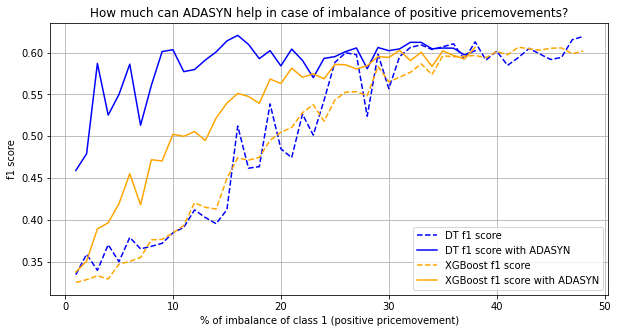

In [76]:
plt.figure(figsize=(10,5))
plt.plot(dt_metrics["f1 DT"],color='blue',linestyle='dashed',label="DT f1 score")
plt.plot(dt_metrics["f1 DT with ADASYN"],color='blue',linestyle='solid',label="DT f1 score with ADASYN")
plt.plot(dt_metrics["f1 XGBoost"],color='orange',linestyle='dashed',label="XGBoost f1 score")
plt.plot(dt_metrics["f1 XGBoost with ADASYN"],color='orange',linestyle='solid',label="XGBoost f1 score with ADASYN")
plt.legend()
plt.grid()
plt.ylabel("f1 score")
plt.xlabel("% of imbalance of class 1 (positive pricemovement)")
plt.title("How much can ADASYN help in case of imbalance of positive pricemovements?")
plt.show()

## Thank you for your attention. 
Do you have questions?